#World Data Science Institute Internship
#Python for Finance Cookbook
#Deep Learning in Finance
# Multilayer perceptrons for time series forecasting
By Brandon Oppong-Antwi, Financial Data Scientist @[Linkedin ](https://https://www.linkedin.com/in/brandon-oppong-antwi-0b2234bb/)

Important Notes on Installations used for Model:

Python Version: Python 3.8.3

Tensorflow Version: Tensorflow 2.3.0

Pytorch Version: Pytorch  1.6.0 with CUDA 101

Operating System: Windows 10

#Multi Layer Perceptrons for Time Series Forecasting

## Abstract 
Deep Learning in Finance comprises a vast field of optimizing neural network architectures in order to solve complex problems that arise in finance.  The fields that deep learning can improve in finance can be creating more reliable fraud detection systems, faster algorithmic trading models, and more accurate price forecasting models. Multilayer perpectrons are an extremely common multi layer feedforward artificial neural network  that generates a set of outputs from a set of inputs. An MLP is characterized by several layers of input nodes connected as a directed graph between the input and output layers. MLP uses backpropogation for training the network. In this exploration, we utilize multilayer perceptron in order to perform time series forecasting on a stock's data in Pytorch. 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 3.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=d63f444dcb31efb80d06dd1a8d34367af2ca3c9c1cfbbfc7b96bc41121a52778
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install torch

In [ ]:
!pip install sklearn

### Introduction 

## Contents:

### *Introduction* 


####  In order to build our model we will first define some relevant terminology 
    - Stocks 
    - Perceptron
    - Multi-layer Perceptron
    - Neural Network
    - Training Set
    - Testing Set



**Stock **

A stock (also known as "shares", "assests", or "equity) is a type of security that signifies proportionate ownership in the issuing corporation. Corporations issue (sell) stocks to raise funds to operate their businesses. There are two main types of stock: common and preferred. Stocks are bought and sold predominantly on stock exchanges, though there can be private sales as well and they are the foundation of nearly every portfolio.

** Perceptron **


The perceptron is a simple binary classification algorithm which was modeled after the rudimentary element of the human brain, the neuron. The perceptron has the ability to divide a set of input signals into two parts—“yes” and “no” or more generally "0" or "1".

**Multi-Layer Perceptron**

When perceptrons are added together with additional perceptrons they form a Multilayer perceptron network. Multilayer perceptrons (MLP) are one of the fundamental parts of neural networks and when they are stacked together can solve complex problems. At the basic level, they consist of three components:

      1. The input layer: A vector of features. 
      2. The hidden layers: Each hidden layer consists of N neurons. 
      3. The output layer: Output of the network; depends on the task (regression/classification).




**Artificial Neural Network**

An artificial neuron network (ANN) is a computational model which is primarily based of the function and structure of biological neural networks. In neural networks information flows through the network and affects the structure of the ANN because a neural network changes - or learns, in a sense - based on that everchanging inputs and outputs.



**Training Set**

The training set is the actual dataset used to train the model. In the case of the ANN, this would be the connections between weights and biases in an artificial neural network of the model.

**Validation Set**

The validation set is the set of data used to provide an unbiased evaluation of whether the model fits on the training dataset while tuning the model's hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

**Testing Set**

The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

**Naive Forecast**

A naive forecast or the naive method of forecasting dictates that we use the previous period to forecast for the next period.In our model we use this to evaluate the perfomance of our model using the mean square error and the root mean squared error.


**BackPropogation or BackPropogation Algorithm**

Backpropagation is a technique used to optimize the weights of an MLP using the outputs as inputs.

In a conventional MLP, random weights are assigned to all the connections. These random weights propagate values through the network to produce the actual output. Naturally, this output would differ from the expected output. The difference between the two values is called the error.

1. Import the libraries:

In [ ]:
import yfinance as yf #yFinance allows us to see the stock price as well as access financial data a company puts out into the stock market
import numpy as np #numpy is a software library written for Python so that we can linear algebra as well as perform mathematical operations on matrices.
import pandas as pd #
import matplotlib.pyplot as plt #matplotlib is a software library for Python that creates statisticals graphs/plots of our data
import torch #machine learning library for python known as Pytorch allows us to use deep learning frameworks

import torch.optim as optim #contains optimization algorithms used for Pytorch
import torch.nn as nn #contains neural network architecture
import torch.nn.functional as F #contains activation functions that our neural network can use
from torch.utils.data import (Dataset, TensorDataset, 
                              DataLoader, Subset) #python iterable over our data. Allows us to extract and transform our data in order for use in our dataset

from sklearn.metrics import mean_squared_error #Mean squared error regression loss for our graphs


print(torch.__version__) #highlight the version of torch we are using

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.6.0+cu101


2. Identify our data from Yahoo Finance as well as define our parameters for the model.

In [ ]:
# data preparation
TICKER = 'IBM' #stock name
START_DATE = '2010-01-02' # start date time period
END_DATE = '2020-10-10' #end date time period 
N_LAGS = 3 #Specify the number of lag classes to be defined by the binning function.

# neural network features
VALID_SIZE = 12 #is the percentage of the data to be held out for validation, 0.2 means 20%.
BATCH_SIZE = 5 #the number of samples that will be propagated through the network.
N_EPOCHS = 1000 #number of iterations or sessions

3. Download and prepare the data:

Before we can fit an MLP model to the dataset, we must transform the data.

The following three data transforms are performed on the dataset prior to fitting a model and making a forecast.

- Transform the time series data so that it is stationary. Specifically, set the number of lag classes to 3. This initialization in the lags is to remove the increasing trend in the data.

- Transform the time series into a supervised learning problem. A supervised learning problem is a predictive models that uses data points with known outcomes. Specifically, we would want the organization of our data to have input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current timestep
- Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1.
These transforms are inverted on forecasts to return them into their original scale before calculating and error score.

In [ ]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False) #download our data from yahoo finance

df = df.resample('M').last()  #resample the time series data based on months
prices = df['Adj Close'].values #get the adjusted close prices from our data

prices

array([ 86.39865875,  90.16745758,  90.94034576,  91.47216034,
        89.27546692,  88.00681305,  91.51338196,  88.19218445,
        96.078125  , 102.85388184, 101.77136993, 105.58436584,
       116.5485611 , 116.92334747, 117.78287506, 123.20719147,
       122.56110382, 124.46195221, 131.93475342, 125.26628876,
       127.423172  , 134.53501892, 137.54130554, 134.52713013,
       140.90667725, 144.48867798, 153.24330139, 152.09024048,
       142.26924133, 144.24578857, 144.54083252, 144.32098389,
       153.65348816, 144.08396912, 141.39665222, 142.49765015,
       151.06761169, 150.03010559, 159.34579468, 151.30755615,
       156.12973022, 143.43795776, 146.38760376, 137.48695374,
       139.68196106, 135.17875671, 136.26109314, 142.24456787,
       133.98605347, 141.19432068, 146.77590942, 149.8107605 ,
       141.39517212, 139.02526855, 147.00160217, 148.35696411,
       146.45146179, 126.83251953, 125.96839142, 124.6245575 ,
       119.08620453, 126.6721344 , 125.54571533, 133.98

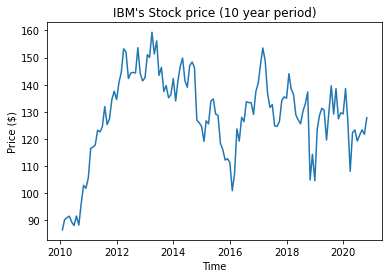

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.index, prices) #plot our stock price over time 
ax.set(title=f"{TICKER}'s Stock price (10 year period)", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Define a function for transforming time series into a dataset for the MLP:

In [ ]:
#create a helper function
#split a multivariate sequence into samples
def create_input_data(series, n_lags=1): #function for transforming time series data contains our series(an array, n_lags)

    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features

    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X, y = [], []
#find the end of this pattern 
    for step in range(len(series) - n_lags): #get a range for the length of the series - n legs at each step
        end_step = step + n_lags
        X.append(series[step:end_step])
        y.append(series[end_step])
    return np.array(X), np.array(y) #gather input or parts of the pattern

5. Transform the considered time series into input for the MLP:

In [ ]:
#create_input_data function to obtain the model's inputs from the times series of stock prices. We used three lagged values as features
X, y = create_input_data(prices, N_LAGS) #array of prices features and the lag classes

X_tensor = torch.from_numpy(X).float() #transform our prices into torch tensor arrays
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1) #transforms our lags into  torch tensor array

6. Create training and validation sets:

In [ ]:
valid_ind = len(X) - VALID_SIZE #last valid_size indices
dataset = TensorDataset(X_tensor, y_tensor) #creation of our tensor dataset for inputs 

train_dataset = Subset(dataset, list(range(valid_ind))) #the dataset the encompasses all our training data 
valid_dataset = Subset(dataset, list(range(valid_ind, len(X)))) #valid dataset

train_loader = DataLoader(dataset=train_dataset, #training dataset loaded with the batch size
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, #valid dataset loaded with the batch size
                          batch_size=BATCH_SIZE)

Inspect the observations from the first batch:

In [ ]:
next(iter(train_loader))[0]

tensor([[86.3987, 90.1675, 90.9403],
        [90.1675, 90.9403, 91.4722],
        [90.9403, 91.4722, 89.2755],
        [91.4722, 89.2755, 88.0068],
        [89.2755, 88.0068, 91.5134]])

In [ ]:
next(iter(train_loader))[1]

tensor([[91.4722],
        [89.2755],
        [88.0068],
        [91.5134],
        [88.1922]])

Check the size of the datasets:

In [ ]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 105 | validation: 12


7. Use naive forecast as a benchmark and evaluate the performance:

In [ ]:
naive_pred = prices[len(prices) - VALID_SIZE - 1:-1]
y_valid = prices[len(prices) - VALID_SIZE:]

naive_mse = mean_squared_error(y_valid, naive_pred) #mean squared error 
naive_rmse = np.sqrt(naive_mse) #root mean square deviation
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 70.89, RMSE: 8.42


8. Define the network's architecture:

In order to build our MLP model we use a feedforward neural network. This feedforward neural network is primarily used for supervised learning in cases where the data to be learned is neither sequential nor time-dependent. Unlike the single-layer perceptron, the feedforward models have hidden layers in between the input and the output layers. After every hidden layer, an activation function is applied to introduce non-linearity. 

MLP Model
We will use a base MLP model with 1 neuron hidden layer, a rectified linear activation function on hidden neurons, and linear activation function on output neurons.

A batch size of 5 is used where possible, with the training data truncated to ensure the number of patterns is divisible by 5. In some cases a batch size of 2 is used.

Normally, the training dataset is shuffled after each batch or each epoch, which can aid in fitting the training dataset on classification and regression problems. Shuffling was turned off for all experiments as it seemed to result in better performance. More studies are needed to confirm this result for time series forecasting.

The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.

In [ ]:
class MLP(nn.Module):
   
#store all the trainable operations in the init function
    def __init__(self, input_size): 
        super(MLP, self).__init__() #based classes that may be using cooperative multiple inheritance will call the correct next parent class function 
        self.linear1 = nn.Linear(input_size, 8) #fully connected layer - size of input samples
        self.linear2 = nn.Linear(8, 4)# fully connected layer - size of input samples
        self.linear3 = nn.Linear(4, 1) #fully connected layer size of input samples
        self.dropout = nn.Dropout(p=0.2) #randomly drops or zeroes some of the elements of the input tensor with probability p= 0.2 or 20%
    
  #forward function defines how to get the output of the neural net through activation functions
    def forward(self, x):
        x = self.linear1(x) #fully connected layer
        x = F.relu(x) #relu activation function. Rectified linear unit to introduce non linearity
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

9. Instantiate the model, the loss function and the optimizer:

In [ ]:
# set seed for reproducibility

torch.manual_seed(42)

## Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update. 
model = MLP(N_LAGS).to(device) 
loss_fn = nn.MSELoss() #creation of the loss function for the neural network
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer function 

In [ ]:
model

MLP(
  (linear1): Linear(in_features=3, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

10. Train the network:

We train the network for our respective number of eposides(epochs). We print every 50 training sessions and the loss associated with each.

In [ ]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

#nested loop
for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad() #gradient descent optimizer zeroes gradients
        #multiply the loss by the batch size to transform the value into the overall sum of the losses and later divided it by the number of observations in the training dataset
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step() #carry out one step of the optimization routine using the specified learning rate
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

   
   #evaluate the networks perfomance
    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset) # loss function already averages over batch size
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 21675.00 	 Valid. loss: 17878.84
<50> - Train. loss: 3096.09 	 Valid. loss: 540.95
<100> - Train. loss: 2574.28 	 Valid. loss: 270.64
<150> - Train. loss: 2143.77 	 Valid. loss: 296.03
<200> - Train. loss: 2413.66 	 Valid. loss: 207.44
<250> - Train. loss: 2753.08 	 Valid. loss: 242.24
<300> - Train. loss: 2149.04 	 Valid. loss: 207.00
<350> - Train. loss: 1932.58 	 Valid. loss: 372.59
<400> - Train. loss: 2684.56 	 Valid. loss: 308.95
<450> - Train. loss: 2266.03 	 Valid. loss: 276.32
<500> - Train. loss: 2403.63 	 Valid. loss: 325.72
<550> - Train. loss: 2269.54 	 Valid. loss: 267.57
<600> - Train. loss: 1983.42 	 Valid. loss: 450.96
<650> - Train. loss: 2319.91 	 Valid. loss: 221.56
<700> - Train. loss: 1993.81 	 Valid. loss: 252.72
<750> - Train. loss: 2085.70 	 Valid. loss: 279.87
<800> - Train. loss: 1869.67 	 Valid. loss: 188.48
<850> - Train. loss: 1914.92 	 Valid. loss: 293.44
<900> - Train. loss: 1824.38 	 Valid. loss: 152.08
<950> - Train. loss: 1974.13 	 

11. Plot the losses over epochs:

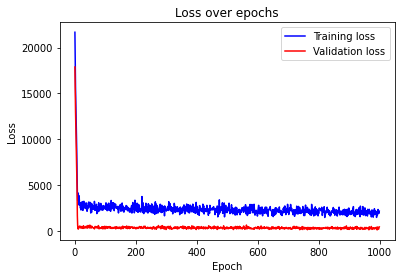

In [ ]:
train_losses = np.array(train_losses) #training losses
valid_losses = np.array(valid_losses) #validation losses

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs', 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

plt.show() 

12. Load the best model (with the lowest validation loss):

In [ ]:
state_dict = torch.load('mlp_checkpoint.pth')  #loaded the state dictionary of the network with the lowest validation loss
model.load_state_dict(state_dict) 

<All keys matched successfully>

13. Obtain the predictions:

In [ ]:
y_pred, y_valid= [], []

with torch.no_grad():

    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)    
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten() #concentanate a list of tensors
y_valid = torch.cat(y_valid).numpy().flatten() #cocentanate a list of tensor

14. Evaluate the predictions:

MLP's forecast - MSE: 93.28, RMSE: 9.66


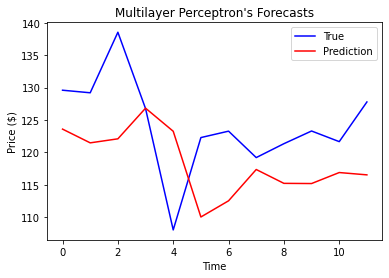

In [ ]:
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label= 'True')
ax.plot(y_pred, color='red', label='Prediction')

ax.set(title="Multilayer Perceptron's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

plt.show()

Naive forecast - MSE: 70.89, RMSE: 8.42



We compare our MLP'S time series forecast to our naive forecast to find that the network is not able to pick up the patterns in time, hence, the predicted line is shifted to the right of the actual one. Using the multilayer perceptron, we obtained results better than with the naïve forecast. This ultimately shows MLP's strength in forecasting time series stock prediction price.


